Used Libraries

In [14]:
import sys
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
from numpy import ones
import tensorflow as tf
from numpy import zeros
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.models import load_model
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, Embedding, Concatenate, BatchNormalization
from matplotlib import pyplot as plt

In [2]:
(trainX, trainy), (testX, testy) = load_data()

In [3]:
trainX.shape

(50000, 32, 32, 3)

Cifar10 Dataset

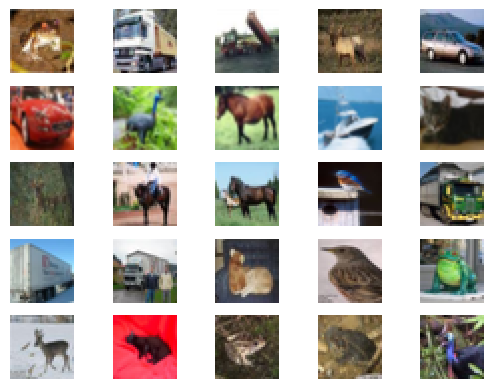

In [4]:
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.axis('off')
    plt.imshow(trainX[i])
plt.show()

Discriminator Model

In [6]:
def define_discriminator(input_shape=(32, 32, 3), num_classes=10):
    #label input
    label_input = Input(shape=(1,))  # Shape: (1,)
    #embedding for categorical input
    #each label (total 10 classes for CIFAR-10) will be represented by a vector of size 50.
    #this vector will be learned by the discriminator.
    label_embedding = Embedding(num_classes, 50)(label_input)  #shape: (1, 50)
    #scale up to image dimensions with linear activation
    embedding_nodes = input_shape[0] * input_shape[1]  #32x32 = 1024
    label_dense = Dense(embedding_nodes)(label_embedding)  #shape: (1, 1024)
    #reshape to additional channel
    label_reshape = Reshape((input_shape[0], input_shape[1], 1))(label_dense)  #shape: (32, 32, 1)
    
    #image input
    image_input = Input(shape=input_shape)  #shape: (32, 32, 3)
    #concatenate label as a channel
    merged_input = Concatenate()([image_input, label_reshape])  #shape: (32, 32, 4) - 3 channels for image and 1 for labels
    
    #downsampling layers (same as unconditional GAN up to the output layer)
    #combining input label with input image and supplying as inputs to the model
    feature_extraction = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(merged_input)  #shape: (16, 16, 128)
    feature_extraction = LeakyReLU(alpha=0.2)(feature_extraction)
    #further downsampling
    feature_extraction = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(feature_extraction)  #shape: (8, 8, 128)
    feature_extraction = LeakyReLU(alpha=0.2)(feature_extraction)
    #flatten feature maps
    feature_extraction = Flatten()(feature_extraction)  #shape: (8192) - (8*8*128=8192)
    #apply dropout
    feature_extraction = Dropout(0.4)(feature_extraction)
    #output layer
    output = Dense(1, activation='sigmoid')(feature_extraction)  #shape: (1)
    
    #define model
    #combining input label with input image and supplying as inputs to the model
    model = Model([image_input, label_input], output)
    #compile model
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

#testing the discriminator model
discriminator_model = define_discriminator()
print(discriminator_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        500         ['input_3[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 1, 1024)      52224       ['embedding_1[0][0]']            
                                                                                                  
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                            

Generator Model

In [7]:
def define_generator(latent_dim, num_classes=10):
    #label input
    label_input = Input(shape=(1,))  # Input shape: (1,)
    #embedding for categorical input
    #each label (total 10 classes for CIFAR-10) will be represented by a vector of size 50.
    label_embedding = Embedding(num_classes, 50)(label_input)  #shape: (1, 50)
    
    #linear multiplication
    embedding_nodes = 8 * 8  #to match the dimensions for concatenation later.
    label_dense = Dense(embedding_nodes)(label_embedding)  #shape: (1, 64)
    #reshape to additional channel
    label_reshape = Reshape((8, 8, 1))(label_dense)
    
    #latent input for image generation
    latent_input = Input(shape=(latent_dim,))  #input shape: (latent_dim,)
    
    #foundation for 8x8 image
    #we will reshape the input latent vector into an 8x8 image as a starting point.
    #the dense layer will have 128 * 8 * 8 nodes so the output can be reshaped into 8x8x128.
    #this part is the same as in an unconditional GAN until the output layer.
    #when defining model inputs, we will combine the input label and the latent input.
    latent_nodes = 128 * 8 * 8
    generator_dense = Dense(latent_nodes)(latent_input)  #shape: (8192)
    generator_dense = LeakyReLU(alpha=0.2)(generator_dense)
    generator_reshape = Reshape((8, 8, 128))(generator_dense)  #shape: (8, 8, 128)
    #merge image generator output and label input
    merged_input = Concatenate()([generator_reshape, label_reshape])  #shape: (8, 8, 129) - Extra channel corresponds to the label
    #upsample to 16x16
    generator_upsample1 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(merged_input)  #shape: (16, 16, 128)
    generator_upsample1 = LeakyReLU(alpha=0.2)(generator_upsample1)
    #upsample to 32x32
    generator_upsample2 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(generator_upsample1)  #shape: (32, 32, 128)
    generator_upsample2 = LeakyReLU(alpha=0.2)(generator_upsample2)
    #output layer
    output_image = Conv2D(3, (8, 8), activation='tanh', padding='same')(generator_upsample2)  #shape: (32, 32, 3)
    
    #define model
    model = Model([latent_input, label_input], output_image)
    return model  #model is not compiled as it is not directly trained like the discriminator.

#testing the generator model
generator_model = define_generator(100, num_classes=10)
print(generator_model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 8192)         827392      ['input_6[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 50)        500         ['input_5[0][0]']                
                                                                                            

GAN

In [8]:
def define_gan(g_model, d_model):
	d_model.trainable = False  #discriminator is trained separately. So set to not trainable.
    
    #connect generator and discriminator
	#first, get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input  #latent vector size and label size
	#get image output from the generator model
	gen_output = g_model.output  #32x32x3
    
	#generator image output and corresponding input label are inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	#define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	#compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

Real Sample Loader

In [9]:
def load_real_samples():
	#load dataset
	(trainX, trainy), (_, _) = load_data()   #cifar
	#convert to floats and scale
	X = trainX.astype('float32')
	#scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5   #Generator uses tanh activation so rescale original images to -1 to 1 to match the output of generator.
	return [X, trainy]

Real Sample Generator

In [10]:
#select real samples
#pick a batch of random real samples to train the GAN
#in fact, we will train the GAN on a half batch of real images and another 
#half batch of fake images. 
#for each real image we assign a label 1 and for fake we assign label 0. 
def generate_real_samples(dataset, n_samples):
	#split into images and labels
	images, labels = dataset  
	#choose random instances
	ix = randint(0, images.shape[0], n_samples)
	#select images and labels
	X, labels = images[ix], labels[ix]
	#generate class labels and assign to y (don't confuse this with the above labels that correspond to cifar labels)
	y = ones((n_samples, 1))  #Label=1 indicating they are real
	return [X, labels], y

In [11]:
#generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	#generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	#reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	#generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

Fake Sample Generator

In [12]:
#use the generator to generate n fake examples, with class labels
#supply the generator, latent_dim and number of samples as input.
#sse the above latent point generator to generate latent points. 
def generate_fake_samples(generator, latent_dim, n_samples):
	#generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	#predict outputs
	images = generator.predict([z_input, labels_input])
	#create class labels
	y = zeros((n_samples, 1))  #label=0 indicating they are fake
	return [images, labels_input], y

Save Generated Images

In [16]:
#this function saves generated image after each epoch
def predict_image(generator_model, epoch_no):
    latent_points, labels = generate_latent_points(100, 1)
    #specify label - generate one label
    label = asarray([1])  #you can change this to generate a specific class (0-9)
    #generate image
    X = generator_model.predict([latent_points, label])
    #scale from [-1, 1] to [0, 1]
    X = (X + 1) / 2.0
    X = (X * 255).astype(np.uint8)
    #convert the generated image to a PIL image
    image = Image.fromarray(X[0])
    #save the image with the epoch number in the filename
    filename = f'generated_image_epoch_{epoch_no}.png'
    image.save(filename)

Training

In [17]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples and a half batch of fake samples, combined in a single batch.

    #suppress detailed TensorFlow output
    tf.get_logger().setLevel('ERROR')

    #function to redirect stdout
    class HiddenPrints:
        def __enter__(self):
            self._original_stdout = sys.stdout
            sys.stdout = open(os.devnull, 'w')

        def __exit__(self, exc_type, exc_val, exc_tb):
            sys.stdout.close()
            sys.stdout = self._original_stdout

    #manually enumerate epochs
    for i in tqdm(range(n_epochs), desc='Training Progress', position=0, leave=True):
        #initialize loss accumulators
        d_loss_real_total, d_loss_fake_total, g_loss_total = 0, 0, 0
        
        #enumerate batches over the training set
        for j in tqdm(range(bat_per_epo), desc=f'Epoch {i+1}/{n_epochs}', position=1, leave=False):
            with HiddenPrints():
                #train the discriminator on real and fake images, separately (half batch each)
                #research showed that separate training is more effective.
                #get randomly selected 'real' samples
                [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)

                #update discriminator model weights
                d_loss_real, _ = d_model.train_on_batch([X_real, labels_real], y_real)
                
                #generate 'fake' examples
                [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
                #update discriminator model weights
                d_loss_fake, _ = d_model.train_on_batch([X_fake, labels], y_fake)
                
                #prepare points in latent space as input for the generator
                [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
                
                #create inverted labels for the fake samples
                y_gan = np.ones((n_batch, 1))
                
                #update the generator via the discriminator's error
                g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
                
            #accumulate losses
            d_loss_real_total += d_loss_real
            d_loss_fake_total += d_loss_fake
            g_loss_total += g_loss

        #calculate average losses for the epoch
        d_loss_real_avg = d_loss_real_total / bat_per_epo
        d_loss_fake_avg = d_loss_fake_total / bat_per_epo
        g_loss_avg = g_loss_total / bat_per_epo

        #print average losses for the epoch
        print(f'Epoch>{i+1}, d1={d_loss_real_avg:.3f}, d2={d_loss_fake_avg:.3f}, g={g_loss_avg:.3f}')
        predict_image(g_model, i+1)

    g_model.save(f'cifar_conditional_generator_{n_epochs}epochs.h5')
    gan_model.save(f'cifar_conditional_gan_{n_epochs}epochs.h5')
    d_model.save(f'cifar_conditional_discriminator_{n_epochs}epochs.h5')

# Suppress TensorFlow INFO logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [15]:
#train the GAN
#size of the latent space
latent_dim = 100
#create the discriminator
d_model = define_discriminator()
#create the generator
g_model = define_generator(latent_dim)
#create the gan
gan_model = define_gan(g_model, d_model)
#load image data
dataset = load_real_samples()

In [30]:
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100)

Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]2024-07-29 21:17:31.674279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-29 21:17:32.085868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-29 21:17:32.270829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-29 21:17:32.872888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch>1, d1=0.467, d2=0.573, g=1.318
1/1 [==============================] - 0s 117ms/step


2024-07-29 21:18:41.701630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
Training Progress:   1%|          | 1/100 [01:10<1:56:00, 70.31s/it]

Epoch>2, d1=0.684, d2=0.635, g=0.909
1/1 [==============================] - 0s 11ms/step


Training Progress:   2%|▏         | 2/100 [02:17<1:52:15, 68.73s/it]

Epoch>3, d1=0.690, d2=0.675, g=0.800
1/1 [==============================] - 0s 12ms/step


Training Progress:   3%|▎         | 3/100 [03:25<1:50:37, 68.42s/it]

Epoch>4, d1=0.660, d2=0.636, g=0.847
1/1 [==============================] - 0s 13ms/step


Training Progress:   4%|▍         | 4/100 [04:33<1:48:51, 68.04s/it]

Epoch>5, d1=0.683, d2=0.673, g=0.788
1/1 [==============================] - 0s 12ms/step


Training Progress:   5%|▌         | 5/100 [05:42<1:48:22, 68.45s/it]

Epoch>6, d1=0.691, d2=0.681, g=0.767
1/1 [==============================] - 0s 12ms/step


Training Progress:   6%|▌         | 6/100 [06:51<1:47:29, 68.61s/it]

Epoch>7, d1=0.682, d2=0.684, g=0.761
1/1 [==============================] - 0s 12ms/step


Training Progress:   7%|▋         | 7/100 [08:00<1:46:34, 68.75s/it]

Epoch>8, d1=0.678, d2=0.680, g=0.769
1/1 [==============================] - 0s 12ms/step


Training Progress:   8%|▊         | 8/100 [09:09<1:45:24, 68.74s/it]

Epoch>9, d1=0.688, d2=0.678, g=0.774
1/1 [==============================] - 0s 12ms/step


Training Progress:   9%|▉         | 9/100 [10:18<1:44:24, 68.84s/it]

Epoch>10, d1=0.686, d2=0.680, g=0.761
1/1 [==============================] - 0s 12ms/step


Training Progress:  10%|█         | 10/100 [11:27<1:43:18, 68.87s/it]

Epoch>11, d1=0.687, d2=0.683, g=0.756
1/1 [==============================] - 0s 12ms/step


Training Progress:  11%|█         | 11/100 [12:36<1:42:15, 68.94s/it]

Epoch>12, d1=0.689, d2=0.684, g=0.752
1/1 [==============================] - 0s 11ms/step


Training Progress:  12%|█▏        | 12/100 [13:45<1:41:03, 68.90s/it]

Epoch>13, d1=0.685, d2=0.684, g=0.752
1/1 [==============================] - 0s 11ms/step


Training Progress:  13%|█▎        | 13/100 [14:52<1:39:22, 68.53s/it]

Epoch>14, d1=0.683, d2=0.678, g=0.768
1/1 [==============================] - 0s 10ms/step


Training Progress:  14%|█▍        | 14/100 [16:00<1:37:52, 68.29s/it]

Epoch>15, d1=0.678, d2=0.672, g=0.787
1/1 [==============================] - 0s 14ms/step


Training Progress:  15%|█▌        | 15/100 [17:08<1:36:29, 68.11s/it]

Epoch>16, d1=0.677, d2=0.668, g=0.792
1/1 [==============================] - 0s 11ms/step


Training Progress:  16%|█▌        | 16/100 [18:15<1:34:57, 67.83s/it]

Epoch>17, d1=0.681, d2=0.668, g=0.794
1/1 [==============================] - 0s 16ms/step


Training Progress:  17%|█▋        | 17/100 [19:23<1:33:42, 67.74s/it]

Epoch>18, d1=0.689, d2=0.676, g=0.778
1/1 [==============================] - 0s 13ms/step


Training Progress:  18%|█▊        | 18/100 [20:32<1:33:16, 68.25s/it]

Epoch>19, d1=0.692, d2=0.679, g=0.773
1/1 [==============================] - 0s 14ms/step


Training Progress:  19%|█▉        | 19/100 [21:41<1:32:27, 68.48s/it]

Epoch>20, d1=0.692, d2=0.682, g=0.762
1/1 [==============================] - 0s 13ms/step


Training Progress:  20%|██        | 20/100 [22:50<1:31:27, 68.59s/it]

Epoch>21, d1=0.695, d2=0.682, g=0.763
1/1 [==============================] - 0s 12ms/step


Training Progress:  21%|██        | 21/100 [23:59<1:30:32, 68.76s/it]

Epoch>22, d1=0.692, d2=0.684, g=0.756
1/1 [==============================] - 0s 12ms/step


Training Progress:  22%|██▏       | 22/100 [25:08<1:29:22, 68.75s/it]

Epoch>23, d1=0.693, d2=0.684, g=0.757
1/1 [==============================] - 0s 12ms/step


Training Progress:  23%|██▎       | 23/100 [26:17<1:28:16, 68.78s/it]

Epoch>24, d1=0.695, d2=0.683, g=0.754
1/1 [==============================] - 0s 12ms/step


Training Progress:  24%|██▍       | 24/100 [27:25<1:27:04, 68.74s/it]

Epoch>25, d1=0.693, d2=0.685, g=0.756
1/1 [==============================] - 0s 12ms/step


Training Progress:  25%|██▌       | 25/100 [28:34<1:25:57, 68.76s/it]

Epoch>26, d1=0.694, d2=0.683, g=0.751
1/1 [==============================] - 0s 12ms/step


Training Progress:  26%|██▌       | 26/100 [29:43<1:24:49, 68.78s/it]

Epoch>27, d1=0.695, d2=0.686, g=0.743
1/1 [==============================] - 0s 12ms/step


Training Progress:  27%|██▋       | 27/100 [30:51<1:23:34, 68.69s/it]

Epoch>28, d1=0.695, d2=0.688, g=0.742
1/1 [==============================] - 0s 13ms/step


Training Progress:  28%|██▊       | 28/100 [32:00<1:22:25, 68.68s/it]

Epoch>29, d1=0.697, d2=0.688, g=0.743
1/1 [==============================] - 0s 12ms/step


Training Progress:  29%|██▉       | 29/100 [33:08<1:21:11, 68.62s/it]

Epoch>30, d1=0.697, d2=0.689, g=0.735
1/1 [==============================] - 0s 12ms/step


Training Progress:  30%|███       | 30/100 [34:17<1:20:01, 68.60s/it]

Epoch>31, d1=0.697, d2=0.690, g=0.733
1/1 [==============================] - 0s 12ms/step


Training Progress:  31%|███       | 31/100 [35:25<1:18:49, 68.54s/it]

Epoch>32, d1=0.697, d2=0.690, g=0.738
1/1 [==============================] - 0s 12ms/step


Training Progress:  32%|███▏      | 32/100 [36:34<1:17:40, 68.53s/it]

Epoch>33, d1=0.695, d2=0.690, g=0.731
1/1 [==============================] - 0s 12ms/step


Training Progress:  33%|███▎      | 33/100 [37:42<1:16:27, 68.47s/it]

Epoch>34, d1=0.696, d2=0.689, g=0.734
1/1 [==============================] - 0s 12ms/step


Training Progress:  34%|███▍      | 34/100 [38:51<1:15:19, 68.48s/it]

Epoch>35, d1=0.695, d2=0.689, g=0.729
1/1 [==============================] - 0s 12ms/step


Training Progress:  35%|███▌      | 35/100 [39:59<1:14:10, 68.47s/it]

Epoch>36, d1=0.695, d2=0.691, g=0.732
1/1 [==============================] - 0s 12ms/step


Training Progress:  36%|███▌      | 36/100 [41:08<1:12:58, 68.42s/it]

Epoch>37, d1=0.695, d2=0.690, g=0.732
1/1 [==============================] - 0s 12ms/step


Training Progress:  37%|███▋      | 37/100 [42:16<1:11:54, 68.48s/it]

Epoch>38, d1=0.696, d2=0.691, g=0.728
1/1 [==============================] - 0s 12ms/step


Training Progress:  38%|███▊      | 38/100 [43:25<1:10:43, 68.45s/it]

Epoch>39, d1=0.695, d2=0.690, g=0.729
1/1 [==============================] - 0s 12ms/step


Training Progress:  39%|███▉      | 39/100 [44:34<1:09:45, 68.61s/it]

Epoch>40, d1=0.694, d2=0.691, g=0.728
1/1 [==============================] - 0s 12ms/step


Training Progress:  40%|████      | 40/100 [45:42<1:08:38, 68.64s/it]

Epoch>41, d1=0.695, d2=0.691, g=0.729
1/1 [==============================] - 0s 12ms/step


Training Progress:  41%|████      | 41/100 [46:51<1:07:26, 68.58s/it]

Epoch>42, d1=0.695, d2=0.690, g=0.727
1/1 [==============================] - 0s 12ms/step


Training Progress:  42%|████▏     | 42/100 [47:59<1:06:12, 68.49s/it]

Epoch>43, d1=0.694, d2=0.691, g=0.728
1/1 [==============================] - 0s 12ms/step


Training Progress:  43%|████▎     | 43/100 [49:08<1:05:06, 68.54s/it]

Epoch>44, d1=0.695, d2=0.691, g=0.728
1/1 [==============================] - 0s 12ms/step


Training Progress:  44%|████▍     | 44/100 [50:16<1:04:02, 68.61s/it]

Epoch>45, d1=0.694, d2=0.691, g=0.727
1/1 [==============================] - 0s 12ms/step


Training Progress:  45%|████▌     | 45/100 [51:25<1:02:49, 68.53s/it]

Epoch>46, d1=0.694, d2=0.690, g=0.727
1/1 [==============================] - 0s 13ms/step


Training Progress:  46%|████▌     | 46/100 [52:34<1:01:45, 68.62s/it]

Epoch>47, d1=0.695, d2=0.691, g=0.726
1/1 [==============================] - 0s 12ms/step


Training Progress:  47%|████▋     | 47/100 [53:42<1:00:36, 68.62s/it]

Epoch>48, d1=0.694, d2=0.691, g=0.729
1/1 [==============================] - 0s 12ms/step


Training Progress:  48%|████▊     | 48/100 [54:51<59:33, 68.71s/it]  

Epoch>49, d1=0.696, d2=0.691, g=0.725
1/1 [==============================] - 0s 12ms/step


Training Progress:  49%|████▉     | 49/100 [56:00<58:24, 68.71s/it]

Epoch>50, d1=0.695, d2=0.692, g=0.725
1/1 [==============================] - 0s 12ms/step


Training Progress:  50%|█████     | 50/100 [57:08<57:13, 68.66s/it]

Epoch>51, d1=0.695, d2=0.691, g=0.723
1/1 [==============================] - 0s 11ms/step


Training Progress:  51%|█████     | 51/100 [58:17<56:00, 68.58s/it]

Epoch>52, d1=0.695, d2=0.692, g=0.724
1/1 [==============================] - 0s 12ms/step


Training Progress:  52%|█████▏    | 52/100 [59:25<54:51, 68.57s/it]

Epoch>53, d1=0.695, d2=0.691, g=0.723
1/1 [==============================] - 0s 13ms/step


Training Progress:  53%|█████▎    | 53/100 [1:00:34<53:41, 68.55s/it]

Epoch>54, d1=0.695, d2=0.692, g=0.726
1/1 [==============================] - 0s 12ms/step


Training Progress:  54%|█████▍    | 54/100 [1:01:42<52:31, 68.50s/it]

Epoch>55, d1=0.695, d2=0.692, g=0.720
1/1 [==============================] - 0s 12ms/step


Training Progress:  55%|█████▌    | 55/100 [1:02:51<51:24, 68.55s/it]

Epoch>56, d1=0.695, d2=0.692, g=0.720
1/1 [==============================] - 0s 12ms/step


Training Progress:  56%|█████▌    | 56/100 [1:04:00<50:18, 68.59s/it]

Epoch>57, d1=0.695, d2=0.692, g=0.722
1/1 [==============================] - 0s 26ms/step


Training Progress:  57%|█████▋    | 57/100 [1:05:08<49:09, 68.59s/it]

Epoch>58, d1=0.696, d2=0.692, g=0.722
1/1 [==============================] - 0s 12ms/step


Training Progress:  58%|█████▊    | 58/100 [1:06:17<48:02, 68.63s/it]

Epoch>59, d1=0.695, d2=0.693, g=0.723
1/1 [==============================] - 0s 12ms/step


Training Progress:  59%|█████▉    | 59/100 [1:07:25<46:53, 68.62s/it]

Epoch>60, d1=0.695, d2=0.692, g=0.718
1/1 [==============================] - 0s 12ms/step


Training Progress:  60%|██████    | 60/100 [1:08:35<45:51, 68.78s/it]

Epoch>61, d1=0.695, d2=0.693, g=0.720
1/1 [==============================] - 0s 12ms/step


Training Progress:  61%|██████    | 61/100 [1:09:43<44:42, 68.79s/it]

Epoch>62, d1=0.695, d2=0.692, g=0.720
1/1 [==============================] - 0s 12ms/step


Training Progress:  62%|██████▏   | 62/100 [1:10:52<43:36, 68.86s/it]

Epoch>63, d1=0.695, d2=0.693, g=0.721
1/1 [==============================] - 0s 12ms/step


Training Progress:  63%|██████▎   | 63/100 [1:12:01<42:26, 68.84s/it]

Epoch>64, d1=0.697, d2=0.692, g=0.717
1/1 [==============================] - 0s 13ms/step


Training Progress:  64%|██████▍   | 64/100 [1:13:10<41:19, 68.88s/it]

Epoch>65, d1=0.695, d2=0.693, g=0.719
1/1 [==============================] - 0s 13ms/step


Training Progress:  65%|██████▌   | 65/100 [1:14:19<40:09, 68.83s/it]

Epoch>66, d1=0.695, d2=0.693, g=0.722
1/1 [==============================] - 0s 12ms/step


Training Progress:  66%|██████▌   | 66/100 [1:15:28<39:00, 68.84s/it]

Epoch>67, d1=0.695, d2=0.693, g=0.719
1/1 [==============================] - 0s 12ms/step


Training Progress:  67%|██████▋   | 67/100 [1:16:37<37:53, 68.88s/it]

Epoch>68, d1=0.695, d2=0.692, g=0.717
1/1 [==============================] - 0s 12ms/step


Training Progress:  68%|██████▊   | 68/100 [1:17:46<36:44, 68.88s/it]

Epoch>69, d1=0.695, d2=0.693, g=0.719
1/1 [==============================] - 0s 12ms/step


Training Progress:  69%|██████▉   | 69/100 [1:18:55<35:35, 68.88s/it]

Epoch>70, d1=0.695, d2=0.693, g=0.717
1/1 [==============================] - 0s 12ms/step


Training Progress:  70%|███████   | 70/100 [1:20:04<34:28, 68.94s/it]

Epoch>71, d1=0.696, d2=0.693, g=0.718
1/1 [==============================] - 0s 12ms/step


Training Progress:  71%|███████   | 71/100 [1:21:12<33:18, 68.90s/it]

Epoch>72, d1=0.694, d2=0.693, g=0.718
1/1 [==============================] - 0s 12ms/step


Training Progress:  72%|███████▏  | 72/100 [1:22:21<32:03, 68.70s/it]

Epoch>73, d1=0.696, d2=0.693, g=0.717
1/1 [==============================] - 0s 12ms/step


Training Progress:  73%|███████▎  | 73/100 [1:23:29<30:50, 68.55s/it]

Epoch>74, d1=0.696, d2=0.692, g=0.716
1/1 [==============================] - 0s 12ms/step


Training Progress:  74%|███████▍  | 74/100 [1:24:37<29:41, 68.53s/it]

Epoch>75, d1=0.695, d2=0.693, g=0.720
1/1 [==============================] - 0s 12ms/step


Training Progress:  75%|███████▌  | 75/100 [1:25:46<28:31, 68.45s/it]

Epoch>76, d1=0.696, d2=0.693, g=0.718
1/1 [==============================] - 0s 12ms/step


Training Progress:  76%|███████▌  | 76/100 [1:26:54<27:22, 68.44s/it]

Epoch>77, d1=0.695, d2=0.693, g=0.719
1/1 [==============================] - 0s 11ms/step


Training Progress:  77%|███████▋  | 77/100 [1:28:02<26:12, 68.39s/it]

Epoch>78, d1=0.695, d2=0.693, g=0.717
1/1 [==============================] - 0s 12ms/step


Training Progress:  78%|███████▊  | 78/100 [1:29:11<25:04, 68.38s/it]

Epoch>79, d1=0.695, d2=0.692, g=0.715
1/1 [==============================] - 0s 13ms/step


Training Progress:  79%|███████▉  | 79/100 [1:30:19<23:58, 68.50s/it]

Epoch>80, d1=0.695, d2=0.692, g=0.718
1/1 [==============================] - 0s 13ms/step


Training Progress:  80%|████████  | 80/100 [1:31:28<22:52, 68.65s/it]

Epoch>81, d1=0.694, d2=0.693, g=0.718
1/1 [==============================] - 0s 12ms/step


Training Progress:  81%|████████  | 81/100 [1:32:37<21:45, 68.71s/it]

Epoch>82, d1=0.696, d2=0.692, g=0.717
1/1 [==============================] - 0s 12ms/step


Training Progress:  82%|████████▏ | 82/100 [1:33:46<20:37, 68.76s/it]

Epoch>83, d1=0.694, d2=0.693, g=0.717
1/1 [==============================] - 0s 12ms/step


Training Progress:  83%|████████▎ | 83/100 [1:34:55<19:30, 68.84s/it]

Epoch>84, d1=0.695, d2=0.692, g=0.716
1/1 [==============================] - 0s 15ms/step


Training Progress:  84%|████████▍ | 84/100 [1:36:05<18:26, 69.15s/it]

Epoch>85, d1=0.695, d2=0.692, g=0.718
1/1 [==============================] - 0s 12ms/step


Training Progress:  85%|████████▌ | 85/100 [1:37:14<17:17, 69.16s/it]

Epoch>86, d1=0.695, d2=0.693, g=0.714
1/1 [==============================] - 0s 12ms/step


Training Progress:  86%|████████▌ | 86/100 [1:38:23<16:06, 69.03s/it]

Epoch>87, d1=0.694, d2=0.693, g=0.722
1/1 [==============================] - 0s 12ms/step


Training Progress:  87%|████████▋ | 87/100 [1:39:32<14:58, 69.09s/it]

Epoch>88, d1=0.695, d2=0.693, g=0.715
1/1 [==============================] - 0s 12ms/step


Training Progress:  88%|████████▊ | 88/100 [1:40:41<13:48, 69.01s/it]

Epoch>89, d1=0.695, d2=0.692, g=0.716
1/1 [==============================] - 0s 12ms/step


Training Progress:  89%|████████▉ | 89/100 [1:41:50<12:38, 68.99s/it]

Epoch>90, d1=0.694, d2=0.693, g=0.717
1/1 [==============================] - 0s 13ms/step


Training Progress:  90%|█████████ | 90/100 [1:42:59<11:29, 68.99s/it]

Epoch>91, d1=0.695, d2=0.693, g=0.715
1/1 [==============================] - 0s 12ms/step


Training Progress:  91%|█████████ | 91/100 [1:44:08<10:20, 68.99s/it]

Epoch>92, d1=0.694, d2=0.693, g=0.714
1/1 [==============================] - 0s 12ms/step


Training Progress:  92%|█████████▏| 92/100 [1:45:17<09:11, 69.00s/it]

Epoch>93, d1=0.695, d2=0.693, g=0.719
1/1 [==============================] - 0s 13ms/step


Training Progress:  93%|█████████▎| 93/100 [1:46:26<08:02, 68.98s/it]

Epoch>94, d1=0.695, d2=0.692, g=0.714
1/1 [==============================] - 0s 14ms/step


Training Progress:  94%|█████████▍| 94/100 [1:47:35<06:53, 68.95s/it]

Epoch>95, d1=0.694, d2=0.693, g=0.715
1/1 [==============================] - 0s 13ms/step


Training Progress:  95%|█████████▌| 95/100 [1:48:44<05:45, 69.03s/it]

Epoch>96, d1=0.695, d2=0.692, g=0.715
1/1 [==============================] - 0s 12ms/step


Training Progress:  96%|█████████▌| 96/100 [1:49:53<04:36, 69.04s/it]

Epoch>97, d1=0.694, d2=0.694, g=0.715
1/1 [==============================] - 0s 12ms/step


Training Progress:  97%|█████████▋| 97/100 [1:51:02<03:27, 69.04s/it]

Epoch>98, d1=0.695, d2=0.693, g=0.714
1/1 [==============================] - 0s 13ms/step


Training Progress:  98%|█████████▊| 98/100 [1:52:11<02:18, 69.05s/it]

Epoch>99, d1=0.695, d2=0.693, g=0.714
1/1 [==============================] - 0s 13ms/step


Training Progress:  99%|█████████▉| 99/100 [1:53:20<01:08, 69.00s/it]

Epoch>100, d1=0.695, d2=0.693, g=0.716
1/1 [==============================] - 0s 12ms/step


Training Progress: 100%|██████████| 100/100 [1:54:29<00:00, 68.69s/it]


Testing the Model

1/1 [==============================] - 0s 99ms/step


2024-07-31 12:02:18.572106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


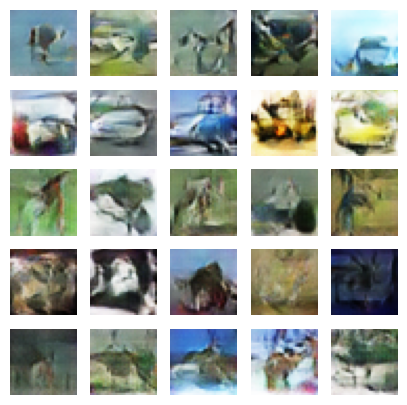

In [20]:
# Load model
model = load_model('/Users/saif/Documents/CGAN/cifar_conditional_generator_100epochs.h5')

# Function to generate latent points
def generate_latent_points(latent_dim, n_samples):
    # Generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # Reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

# Specify the classes you want to generate images for
selected_classes = [0, 1, 2, 3, 4]
n_samples_per_class = 5
n_classes = len(selected_classes)
total_samples = n_samples_per_class * n_classes

# Generate latent points
latent_dim = 100
latent_points = generate_latent_points(latent_dim, total_samples)

# Generate labels for the specified classes
labels = asarray([x for x in selected_classes for _ in range(n_samples_per_class)])

# Generate images
X = model.predict([latent_points, labels])

# Scale from [-1, 1] to [0, 1]
X = (X + 1) / 2.0
X = (X * 255).astype(np.uint8)

# Plot the result (5 sets of images, all images in a column should be of the same class)
def show_plot(examples, n_classes, n_samples_per_class):
    fig, axes = plt.subplots(n_classes, n_samples_per_class, figsize=(n_samples_per_class, n_classes))
    for i in range(n_classes):
        for j in range(n_samples_per_class):
            ax = axes[i, j]
            ax.axis('off')
            ax.imshow(examples[i * n_samples_per_class + j, :, :, :])
    plt.show()

show_plot(X, n_classes, n_samples_per_class)